## Training des Models V6

In diesem Programmcode wird der Datensatz geldaden, Verarbeitet und das CNN trainiert.
Nutzung von ChatGPT: 
Die Dataloader Class  wurde mit Hilfe von generativer KI erstellt.

Prompt:
" Erstelle mir eine Pytorch Dataloader Klasse um aus einem Datensatz Audiodatein zu laden und diese zu verarbeiten. Dies als Grundgerüst"

In [1]:
import os
from contextlib import suppress

from tqdm.auto import tqdm

import distiller # required for quantization

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchaudio
import torchaudio.transforms as T

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np

from errno import ENOENT

import max78_modules.ai8x as ai8x

%matplotlib inline

In [2]:
torch.cuda.is_available()


True

# Setup device

In [3]:
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

## 85 für max78000, 87 für max78002
args = Args(act_mode_8bit=False)
ai8x.set_device(85, simulate=False, round_avg=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Configuring device: MAX78000, simulate=False.


# Setup TUT2017 dataset and dataloader

- Hier kann man die Parameter für Audio Preprocessing festlegen
- Audio To mono fehlt noch

In [4]:
class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None, sample_rate=16000):
        """
        Args:
            root_dir (string): Directory with all the folders (e.g., cafe, car, city_center, etc.).
            transform (callable, optional): Optional transform to be applied on a sample.
            sample_rate (int): Desired sample rate for the audio files.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.sample_rate = sample_rate
        self.data = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        
        # Build the dataset
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for file_name in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, file_name)
                    if file_name.endswith('.wav'):  # Check for .wav files
                        self.data.append(file_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data[idx]
        label = self.labels[idx]
        
        # Load the audio file
        waveform, sample_rate = torchaudio.load(file_path)
        
        waveform = waveform.mean(dim=0)  # Mittelung über die Kanal-Dimension

        # Resample if necessary
        if sample_rate != self.sample_rate:
            resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.sample_rate)
            waveform = resample_transform(waveform)

        

        window_length = int(sample_rate*0.092)
        hop_length = int(sample_rate*0.046)
        
        transform_mel = T.MFCC(sample_rate=sample_rate,
                           n_mfcc=40,
                           melkwargs={"n_fft": window_length,
                                      "hop_length": hop_length,
                                      "n_mels": 40,
                                      "center": False},
                          ) 
        waveform = transform_mel(waveform)

        transform_normalize = ai8x.normalize(args = args)
        waveform = transform_normalize(waveform)
        
        
        return waveform, label

In [5]:
train_dataset_path = "/home/student42/Documents/Datset/KerasTUT2017_16khz_FULL/Training"
val_dataset_path = "/home/student42/Documents/Datset/KerasTUT2017_16khz_FULL/Validation"
test_dataset_path = "/home/student42/Documents/Datset/KerasTUT2017_16khz_FULL/Testing"

batch_size = 128
TUT2017_train = AudioDataset(root_dir=train_dataset_path, transform=None, sample_rate=14000)
TUT2017_val = AudioDataset(root_dir=val_dataset_path, transform=None, sample_rate=14000)
TUT2017_test = AudioDataset(root_dir=test_dataset_path, transform=None, sample_rate=14000)

dataset_train = DataLoader(TUT2017_train, batch_size=batch_size, shuffle=True)
dataset_val = DataLoader(TUT2017_val, batch_size=batch_size, shuffle=True)
dataset_test = DataLoader(TUT2017_test, batch_size=batch_size, shuffle=True)

dataset_labels = [0, 1, 2, 3, 4, 5, 6]

In [6]:
# Beispiel: Zugriff auf Daten aus dem Train-Loader
for waveforms, labels in dataset_train:
    print("Train Data - Waveforms Shape:", waveforms.shape)
    print("Train Data - Labels Shape:", labels.shape)
    break

# Zugriff auf Validierungs- und Test-Daten
for waveforms, labels in dataset_val:
    print("Validation Data - Waveforms Shape:", waveforms.shape)
    print("Validation Data - Labels Shape:", labels.shape)
    break

Train Data - Waveforms Shape: torch.Size([128, 40, 189])
Train Data - Labels Shape: torch.Size([128])
Validation Data - Waveforms Shape: torch.Size([128, 40, 189])
Validation Data - Labels Shape: torch.Size([128])


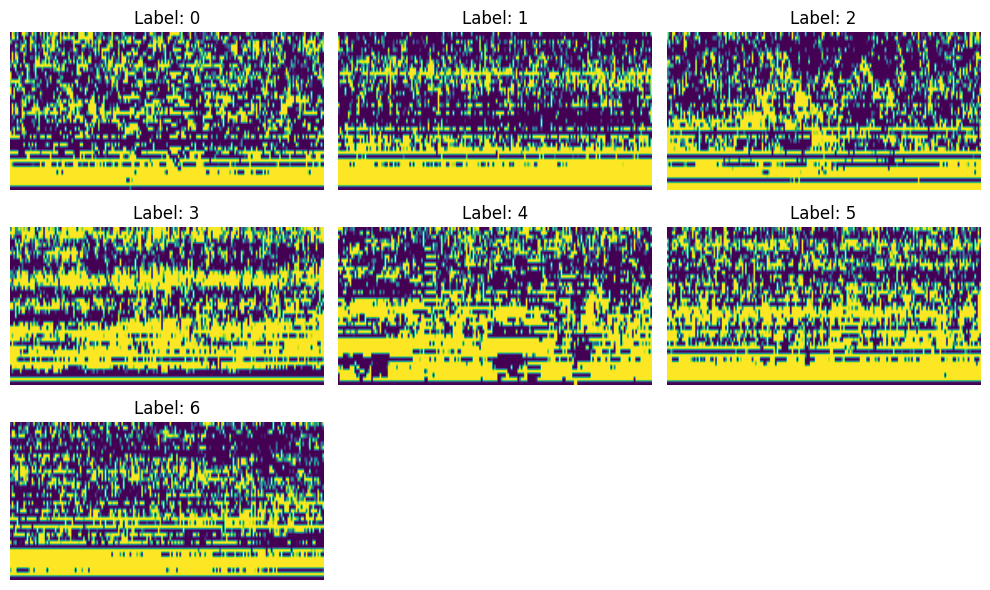

In [7]:
import matplotlib.pyplot as plt

# Funktion, um Beispiele für jedes Label zu finden
def plot_examples_for_labels(dataset, num_labels=7, examples_per_label=1):
    labels_found = set()
    examples = []
    
    # Suche Beispiele für jedes Label
    for idx in range(len(dataset)):
        audio_data, label = dataset[idx]
        if label not in labels_found:
            examples.append((audio_data, label))
            labels_found.add(label)
        
        # Beende die Suche, wenn für alle Labels ein Beispiel gefunden wurde
        if len(labels_found) == num_labels:
            break

    # Plot der Beispiele
    cols = 3  # Anzahl der Bilder pro Reihe
    rows = (num_labels // cols) + (num_labels % cols > 0)  # Zeilenanzahl berechnen
    fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
    axes = axes.flatten()  # Flach machen für einfaches Iterieren

    for i, (audio_data, label) in enumerate(examples):
        if len(audio_data.shape) > 1:  # Falls Mel-Spektrogramm
            axes[i].imshow(audio_data.numpy(), aspect='auto', origin='lower', cmap='viridis')
        else:  # Falls Rohdaten (1D-Signal)
            axes[i].plot(audio_data.numpy())

        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')  # Achsen ausblenden

    # Leere Subplots ausblenden
    for j in range(len(examples), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Nutze die Funktion mit deinem Dataset
if isinstance(dataset_train, torch.utils.data.DataLoader):  # Direkt auf Dataset zugreifen
    dataset = dataset_train.dataset
else:
    dataset = dataset_train

plot_examples_for_labels(dataset, num_labels=7)


# Create CNN Model

## Als backup!

class Acoustic_Scene_Detection(nn.Module):
    def __init__(
            self,
            num_classes=21,
            num_channels=128,
            dimensions=(128, 1),  # pylint: disable=unused-argument
            bias=False,
            **kwargs

    ):
        super().__init__()
        self.step1 = ai8x.FusedMaxPoolConv1dReLU(1, 64, 5, stride=1, padding=1, bias=bias, **kwargs)
        self.step2 = ai8x.FusedMaxPoolConv1dReLU(1,128, 5, stride=1, padding=1, bias=bias, **kwargs)
        self.step3 = ai8x.FusedMaxPoolConv1dReLU(1,256, 5, stride=1, padding=1, bias=bias, **kwargs)
        self.flatten = torch.nn.Flatten(start_dim=1, end_dim=-1),
        self.dropout = nn.Dropout(0.5)
        self.fc1 = ai8x.Linear(512, num_classes, bias=bias, **kwargs)
    
    def forward(self, x):
        x = self.step1(x)
        x = self.step2(x)
        x = self.step3(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

NUM_CLASSES = 7
model = Acoustic_Scene_Detection()

In [8]:


class Custom1DCNNForImage(nn.Module):
    
    def __init__(
            self,
            num_classes=7,
            num_channels=40,
            bias=True,
            **kwargs

    ):
        super(Custom1DCNNForImage, self).__init__()


        self.drop = nn.Dropout(p=0.65)
        # Erste Convolutional Layer mit Batch-Normalisierung und ReLU
        self.conv1 = ai8x.FusedConv1dBNReLU(num_channels, 64, 5, stride=1, padding=1,
                                                bias=bias, **kwargs)
        
        # # torch.Size([1, 64, 212])
        self.conv2 = ai8x.FusedMaxPoolConv1dBNReLU(64, 128, 3, stride=1, padding=0,
                                                 bias=bias, **kwargs)
        # torch.Size([1, 128, 210])
        self.conv3 = ai8x.FusedMaxPoolConv1dReLU(128, 256, 5, stride=1, padding=1,
                                                       bias=bias, **kwargs)
        # # torch.Size([1, 96, 99])
        self.conv4 = ai8x.FusedAvgPoolConv1dReLU(256, 32, 3, stride=1, padding=1,
                                                     bias=bias, **kwargs)
        # # torch.Size([1, 32, 21])
        self.fc = ai8x.Linear(672, num_classes, bias=bias, wide=True, **kwargs)

    def forward(self, x):  # pylint: disable=arguments-differ
        """Forward prop"""
        # Run CNN
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        
        
        x = self.conv4(x)
        x = self.drop(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


# Beispielinstanz
model = Custom1DCNNForImage()

# Test mit einem Beispielinput
#input_tensor = torch.randn(1, 40, 216)  # Batch size 1, 40 Kanäle, Länge 216
#output = model(input_tensor)
#print(output.shape)  # Sollte (1, 7) sein



# Define loss function and optimizer

In [9]:
compression_scheduler = distiller.CompressionScheduler(model)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.25, patience=2, min_lr=1e-7)
criterion = nn.CrossEntropyLoss()

qat_policy = { 'weight_bits': 8 }
vloss = 10**6
steps_per_epoch = (len(dataset_train.sampler) + batch_size - 1)

# Train the model

In [10]:
# Define the number of training epochs
num_epochs = 50    # FP training epochs
num_epochs_qat = 50  # QAT training epochs


Epoch [1/50] - Loss: 2.2208 - Train Accuracy: 15.66%
Epoch [1/50] - Test Accuracy: 30.41%


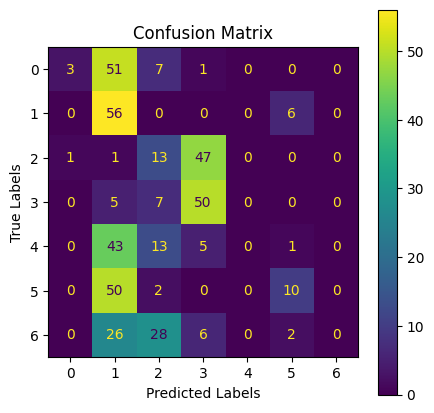


Epoch [2/50] - Loss: 1.8527 - Train Accuracy: 23.72%
Epoch [2/50] - Test Accuracy: 19.35%


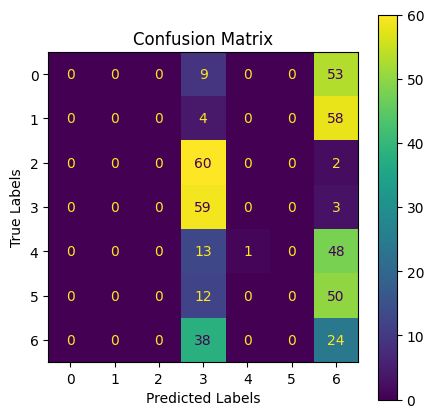


Epoch [3/50] - Loss: 1.7343 - Train Accuracy: 26.47%
Epoch [3/50] - Test Accuracy: 30.88%


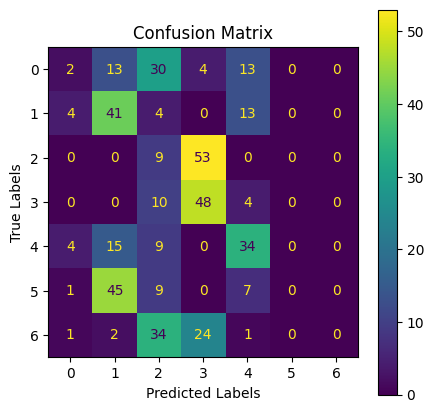


Epoch [4/50] - Loss: 1.7235 - Train Accuracy: 27.98%
Epoch [4/50] - Test Accuracy: 22.58%


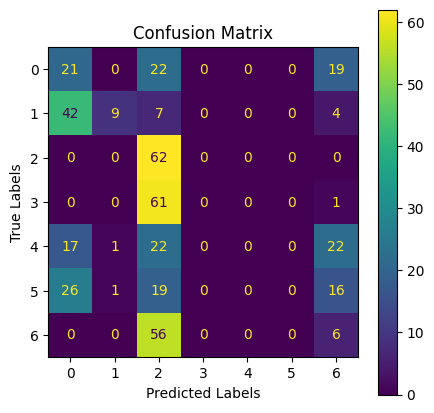


Epoch [5/50] - Loss: 1.6066 - Train Accuracy: 28.57%
Epoch [5/50] - Test Accuracy: 27.88%


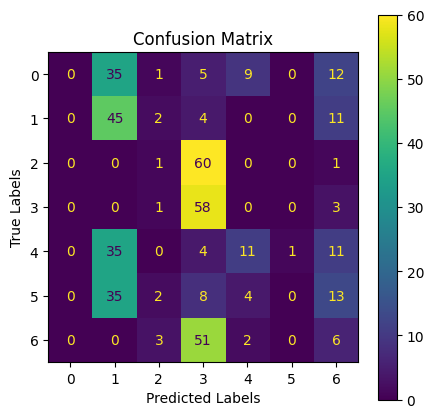


Epoch [6/50] - Loss: 1.4820 - Train Accuracy: 32.37%
Epoch [6/50] - Test Accuracy: 35.25%


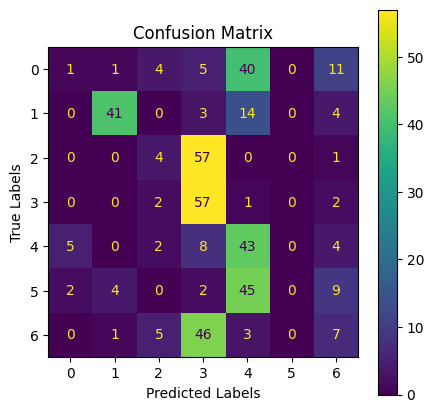


Epoch [7/50] - Loss: 1.2855 - Train Accuracy: 42.20%
Epoch [7/50] - Test Accuracy: 43.78%


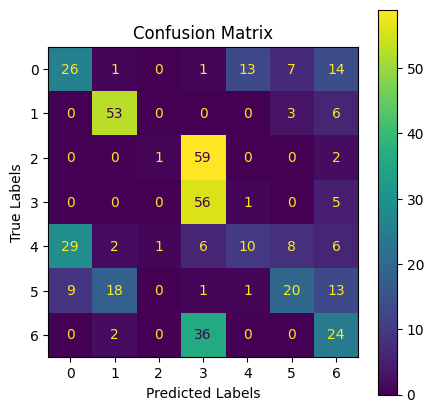


Epoch [8/50] - Loss: 1.1020 - Train Accuracy: 51.11%
Epoch [8/50] - Test Accuracy: 40.78%


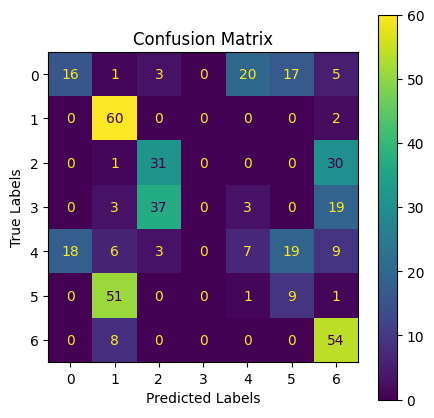


Epoch [9/50] - Loss: 0.9389 - Train Accuracy: 57.86%
Epoch [9/50] - Test Accuracy: 51.15%


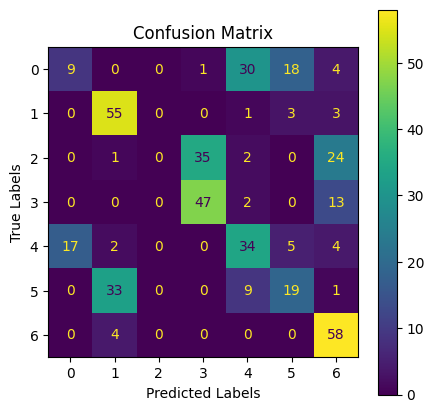


Epoch [10/50] - Loss: 0.8459 - Train Accuracy: 65.60%
Epoch [10/50] - Test Accuracy: 53.69%


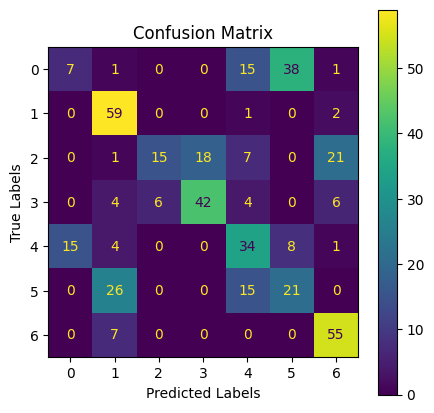


Epoch [11/50] - Loss: 0.8113 - Train Accuracy: 68.22%
Epoch [11/50] - Test Accuracy: 60.14%


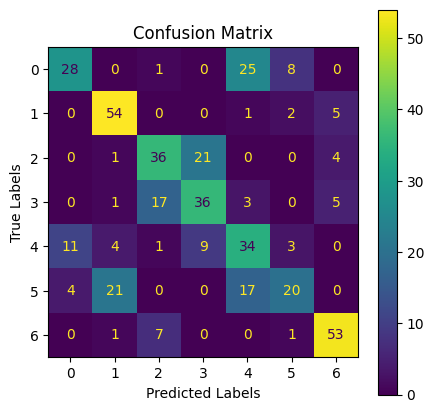


Epoch [12/50] - Loss: 0.5715 - Train Accuracy: 78.24%
Epoch [12/50] - Test Accuracy: 63.13%


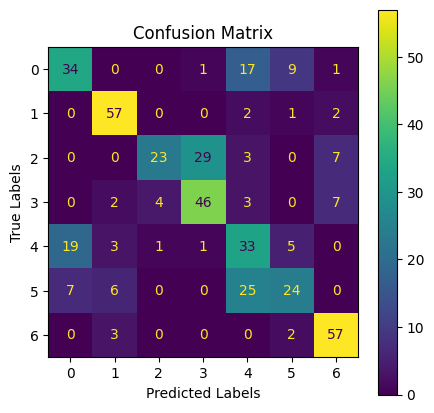


Epoch [13/50] - Loss: 0.5266 - Train Accuracy: 80.28%
Epoch [13/50] - Test Accuracy: 66.13%


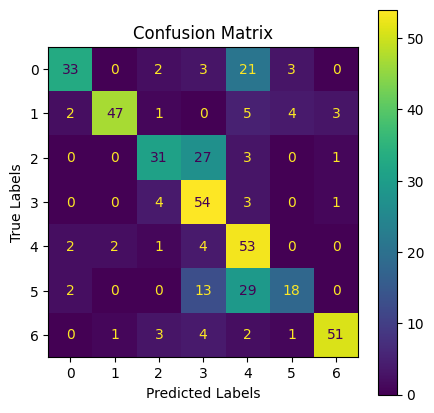


Epoch [14/50] - Loss: 0.4580 - Train Accuracy: 85.12%
Epoch [14/50] - Test Accuracy: 64.06%


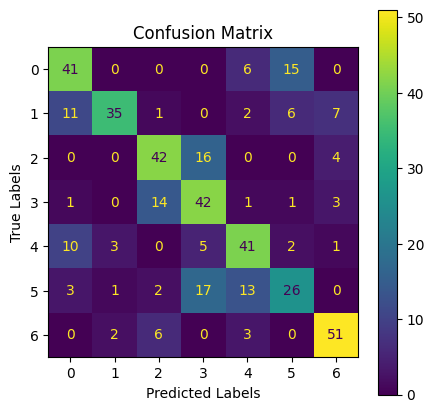


Epoch [15/50] - Loss: 0.3437 - Train Accuracy: 88.27%
Epoch [15/50] - Test Accuracy: 61.06%


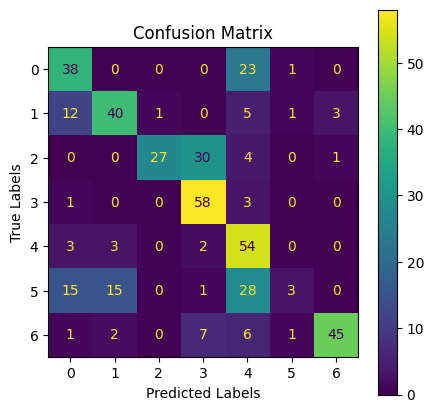


Epoch [16/50] - Loss: 0.3134 - Train Accuracy: 89.91%
Epoch [16/50] - Test Accuracy: 48.16%


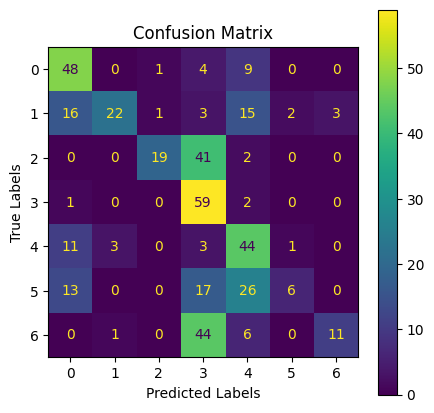


Epoch [17/50] - Loss: 0.2942 - Train Accuracy: 91.81%
Epoch [17/50] - Test Accuracy: 65.90%


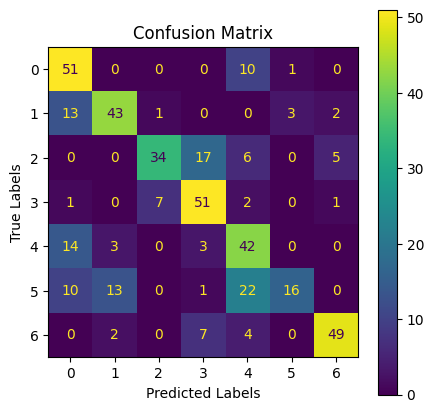


Epoch [18/50] - Loss: 0.2160 - Train Accuracy: 93.12%
Epoch [18/50] - Test Accuracy: 67.51%


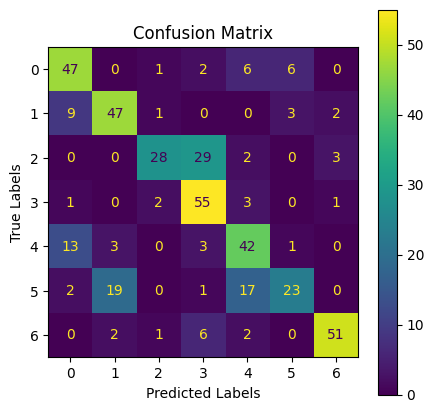


Epoch [19/50] - Loss: 0.1770 - Train Accuracy: 94.17%
Epoch [19/50] - Test Accuracy: 69.82%


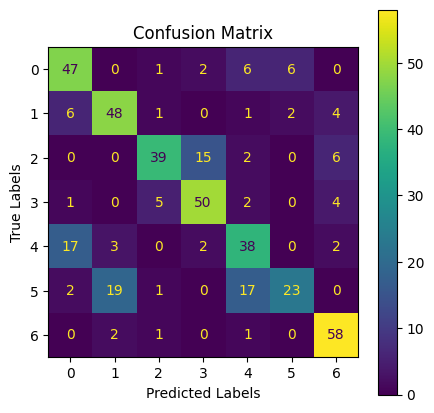


Epoch [20/50] - Loss: 0.1679 - Train Accuracy: 94.76%
Epoch [20/50] - Test Accuracy: 68.66%


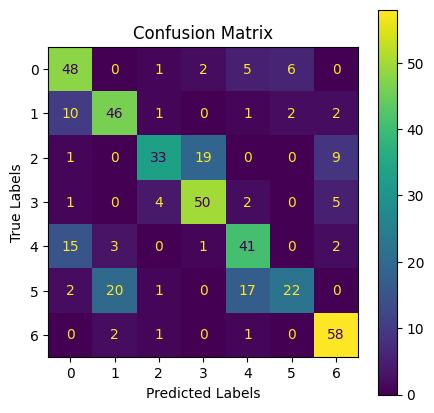


Epoch [21/50] - Loss: 0.1397 - Train Accuracy: 95.48%
Epoch [21/50] - Test Accuracy: 69.12%


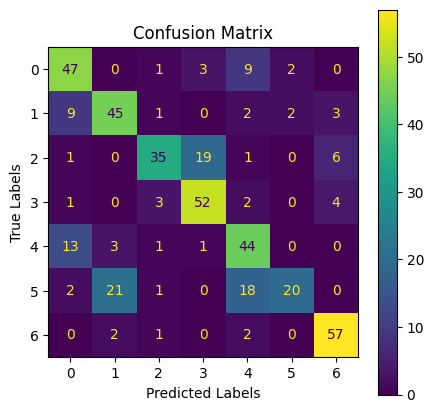


Epoch [22/50] - Loss: 0.1237 - Train Accuracy: 96.00%
Epoch [22/50] - Test Accuracy: 69.12%


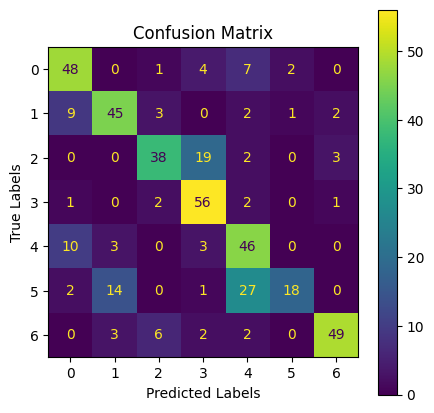


Epoch [23/50] - Loss: 0.1239 - Train Accuracy: 96.20%
Epoch [23/50] - Test Accuracy: 67.51%


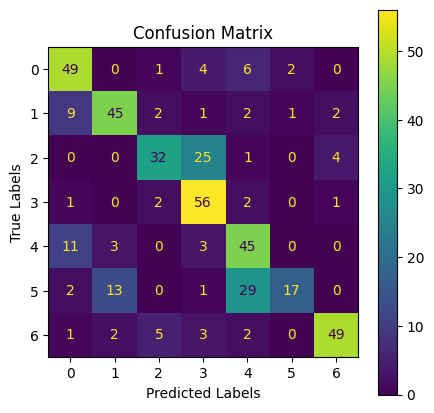


Epoch [24/50] - Loss: 0.1186 - Train Accuracy: 95.94%
Epoch [24/50] - Test Accuracy: 68.66%


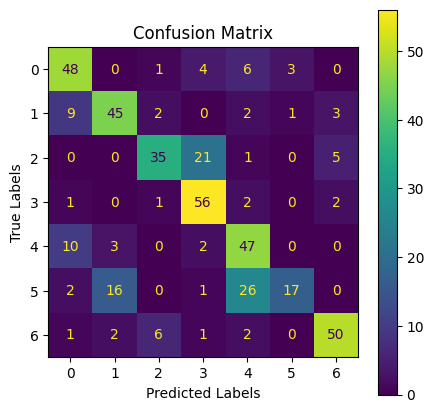


Epoch [25/50] - Loss: 0.1097 - Train Accuracy: 96.53%
Epoch [25/50] - Test Accuracy: 68.89%


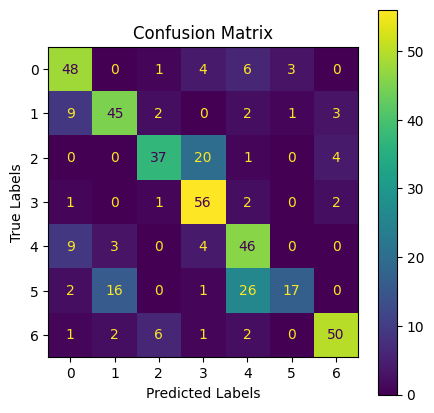


Epoch [26/50] - Loss: 0.1096 - Train Accuracy: 96.66%
Epoch [26/50] - Test Accuracy: 67.97%


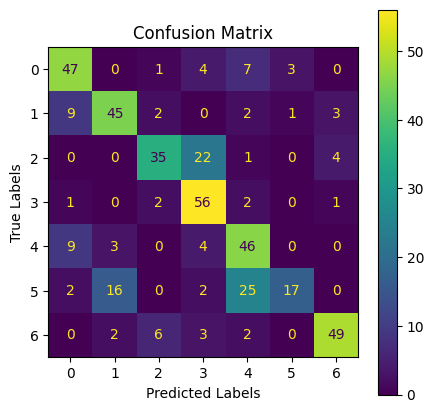


Epoch [27/50] - Loss: 0.1136 - Train Accuracy: 96.26%
Epoch [27/50] - Test Accuracy: 67.97%


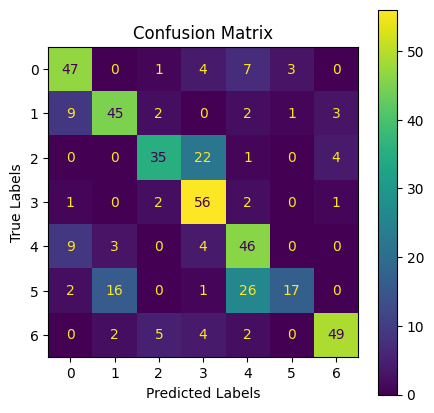


Epoch [28/50] - Loss: 0.1028 - Train Accuracy: 96.72%
Epoch [28/50] - Test Accuracy: 68.43%


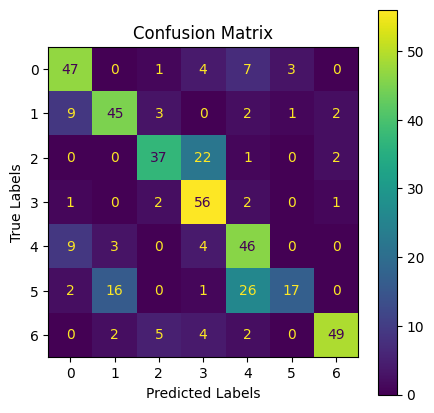


Epoch [29/50] - Loss: 0.1023 - Train Accuracy: 97.44%
Epoch [29/50] - Test Accuracy: 68.66%


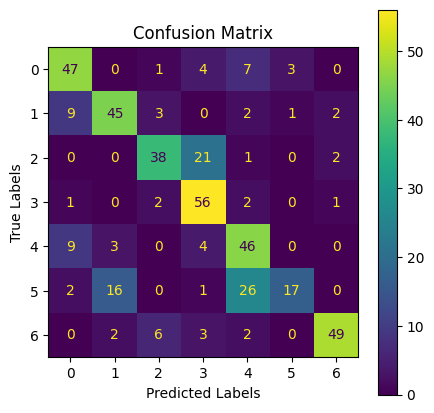


Epoch [30/50] - Loss: 0.0939 - Train Accuracy: 97.38%
Epoch [30/50] - Test Accuracy: 68.66%


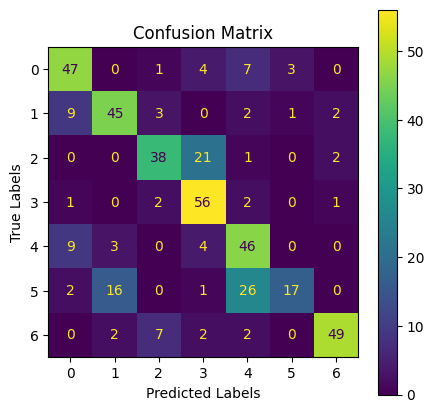


Epoch [31/50] - Loss: 0.1084 - Train Accuracy: 96.79%
Epoch [31/50] - Test Accuracy: 68.66%


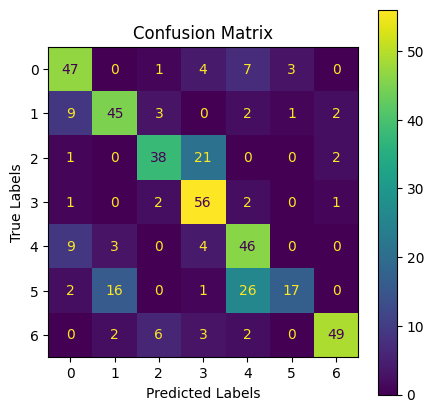


Epoch [32/50] - Loss: 0.1130 - Train Accuracy: 96.72%
Epoch [32/50] - Test Accuracy: 68.66%


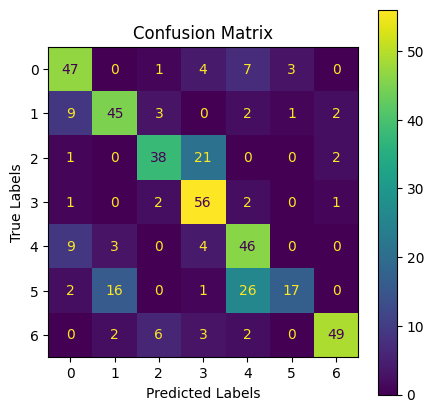


Epoch [33/50] - Loss: 0.1060 - Train Accuracy: 96.59%
Epoch [33/50] - Test Accuracy: 68.89%


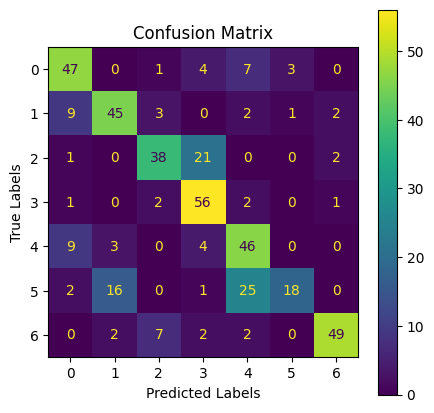


Epoch [34/50] - Loss: 0.0938 - Train Accuracy: 97.44%
Epoch [34/50] - Test Accuracy: 69.12%


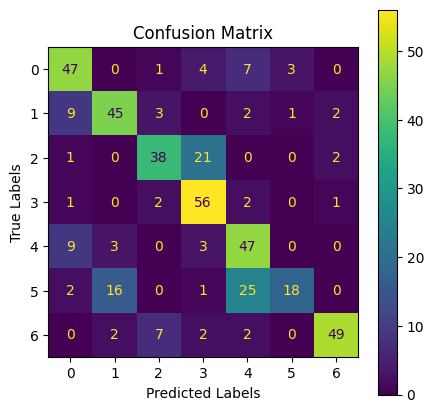


Epoch [35/50] - Loss: 0.1092 - Train Accuracy: 96.59%
Epoch [35/50] - Test Accuracy: 68.66%


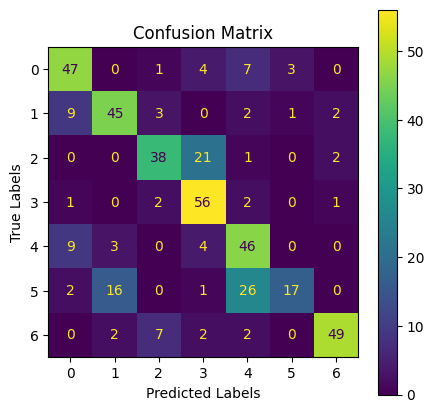


Epoch [36/50] - Loss: 0.1072 - Train Accuracy: 97.05%
Epoch [36/50] - Test Accuracy: 68.66%


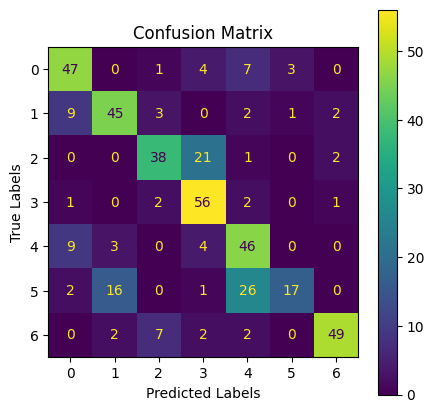


Epoch [37/50] - Loss: 0.1054 - Train Accuracy: 96.66%
Epoch [37/50] - Test Accuracy: 68.66%


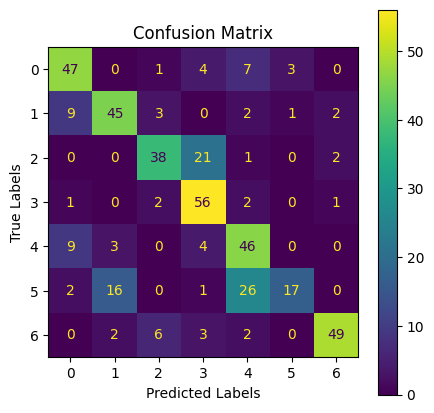


Epoch [38/50] - Loss: 0.0918 - Train Accuracy: 97.18%
Epoch [38/50] - Test Accuracy: 68.66%


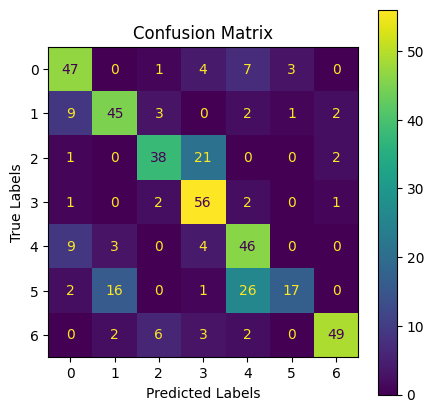


Epoch [39/50] - Loss: 0.1059 - Train Accuracy: 97.12%
Epoch [39/50] - Test Accuracy: 68.89%


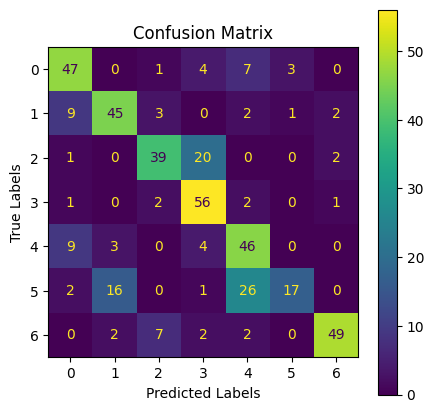


Epoch [40/50] - Loss: 0.0986 - Train Accuracy: 97.18%
Epoch [40/50] - Test Accuracy: 68.89%


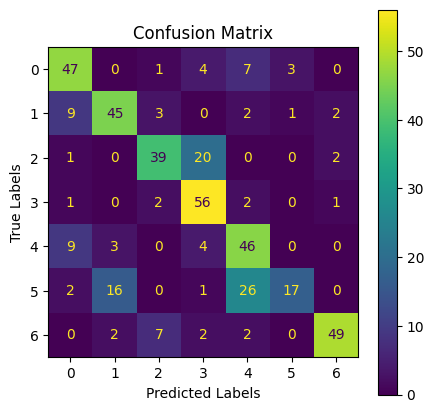


Epoch [41/50] - Loss: 0.0994 - Train Accuracy: 97.12%
Epoch [41/50] - Test Accuracy: 68.89%


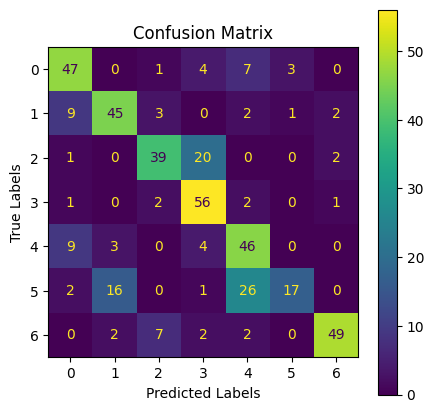


Epoch [42/50] - Loss: 0.1112 - Train Accuracy: 96.40%
Epoch [42/50] - Test Accuracy: 68.89%


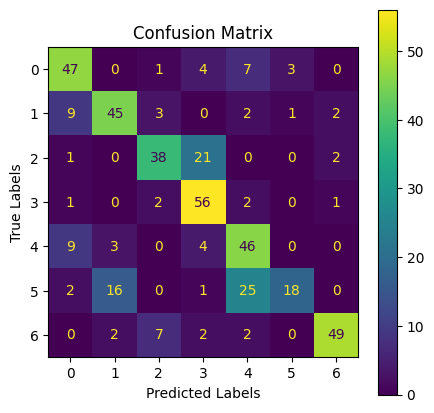


Epoch [43/50] - Loss: 0.0988 - Train Accuracy: 96.92%
Epoch [43/50] - Test Accuracy: 68.66%


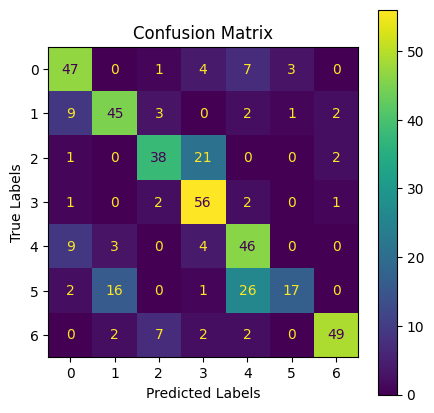


Epoch [44/50] - Loss: 0.1152 - Train Accuracy: 96.26%
Epoch [44/50] - Test Accuracy: 68.66%


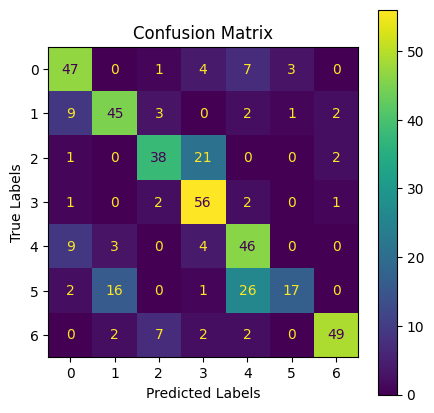


Epoch [45/50] - Loss: 0.1089 - Train Accuracy: 96.66%
Epoch [45/50] - Test Accuracy: 68.66%


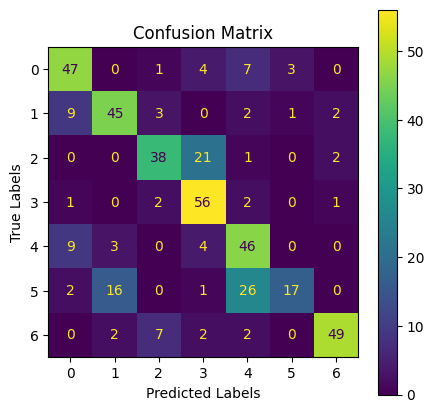


Epoch [46/50] - Loss: 0.0954 - Train Accuracy: 97.71%
Epoch [46/50] - Test Accuracy: 68.66%


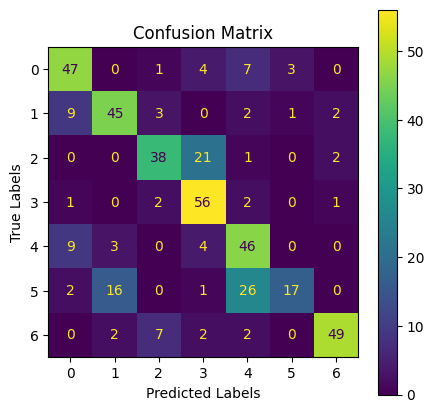


Epoch [47/50] - Loss: 0.1131 - Train Accuracy: 96.46%
Epoch [47/50] - Test Accuracy: 68.66%


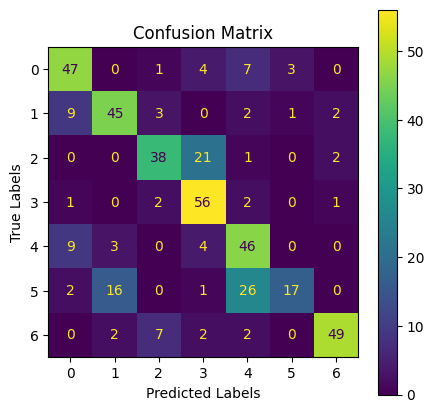


Epoch [48/50] - Loss: 0.1024 - Train Accuracy: 96.72%
Epoch [48/50] - Test Accuracy: 68.89%


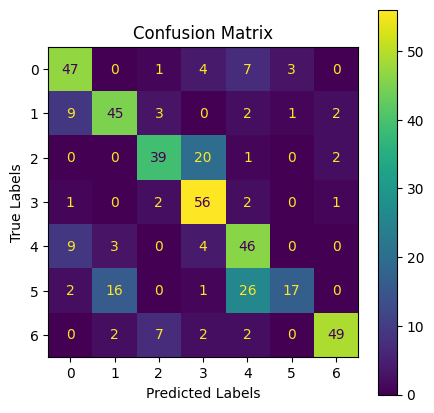


Epoch [49/50] - Loss: 0.1111 - Train Accuracy: 96.59%
Epoch [49/50] - Test Accuracy: 68.89%


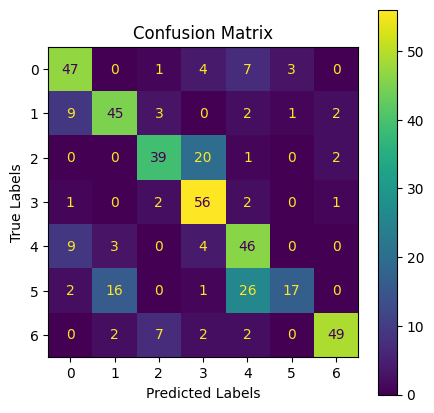


Epoch [50/50] - Loss: 0.1228 - Train Accuracy: 96.00%
Epoch [50/50] - Test Accuracy: 68.66%


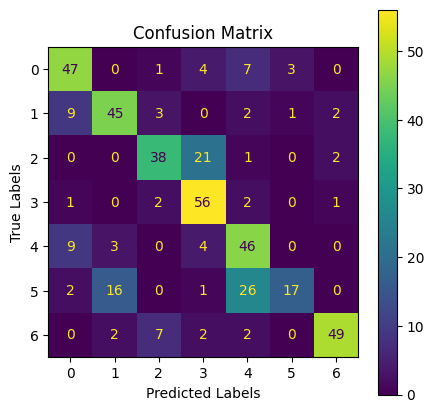

Moving model to QAT!



Epoch [51/50] - Loss: 0.0949 - Train Accuracy: 96.99%
Epoch [51/50] - Test Accuracy: 68.66%


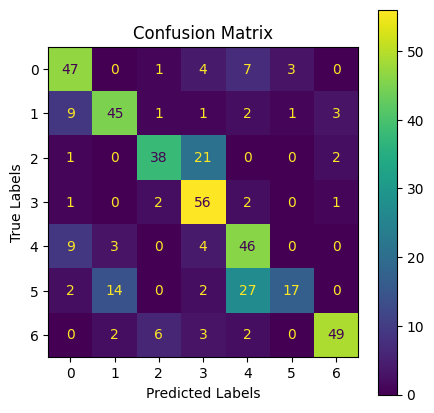


Epoch [52/50] - Loss: 0.0917 - Train Accuracy: 97.44%
Epoch [52/50] - Test Accuracy: 68.89%


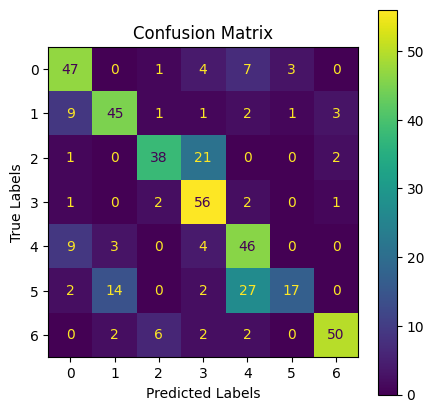


Epoch [53/50] - Loss: 0.0803 - Train Accuracy: 97.44%
Epoch [53/50] - Test Accuracy: 68.66%


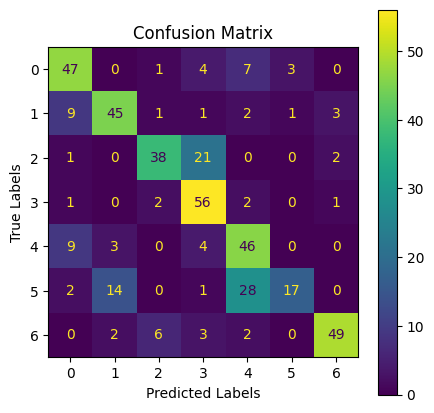


Epoch [54/50] - Loss: 0.0884 - Train Accuracy: 97.31%
Epoch [54/50] - Test Accuracy: 68.66%


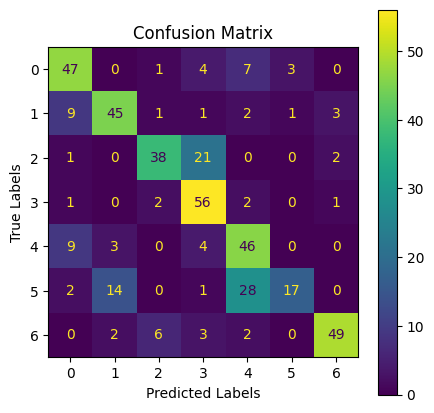


Epoch [55/50] - Loss: 0.1069 - Train Accuracy: 97.12%
Epoch [55/50] - Test Accuracy: 68.66%


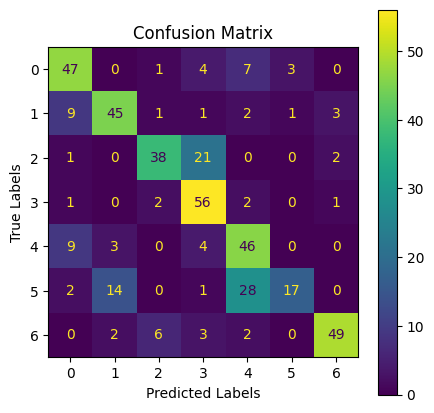


Epoch [56/50] - Loss: 0.1081 - Train Accuracy: 97.44%
Epoch [56/50] - Test Accuracy: 68.89%


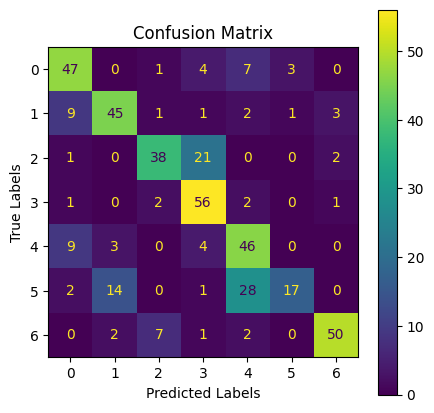


Epoch [57/50] - Loss: 0.0932 - Train Accuracy: 97.05%
Epoch [57/50] - Test Accuracy: 68.89%


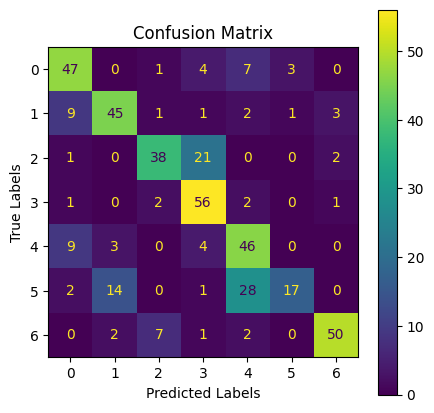


Epoch [58/50] - Loss: 0.1133 - Train Accuracy: 97.05%
Epoch [58/50] - Test Accuracy: 68.89%


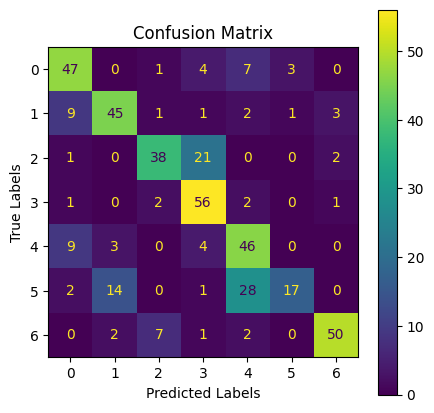


Epoch [59/50] - Loss: 0.0980 - Train Accuracy: 97.25%
Epoch [59/50] - Test Accuracy: 68.89%


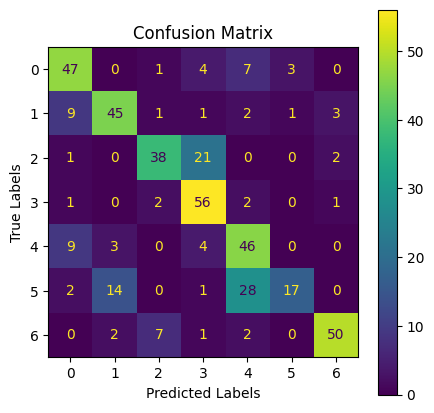


Epoch [60/50] - Loss: 0.0875 - Train Accuracy: 97.31%
Epoch [60/50] - Test Accuracy: 68.89%


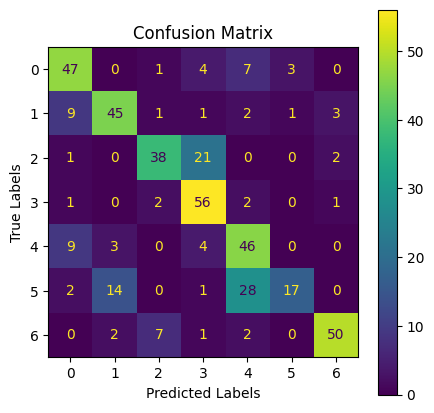


Epoch [61/50] - Loss: 0.0914 - Train Accuracy: 97.25%
Epoch [61/50] - Test Accuracy: 68.89%


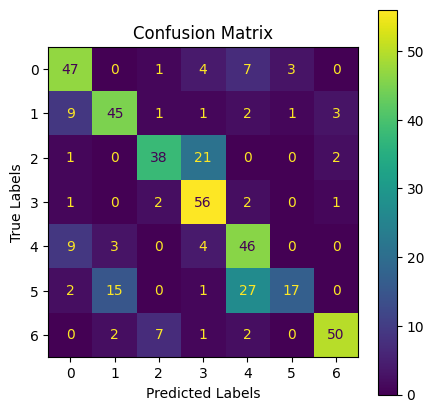


Epoch [62/50] - Loss: 0.0875 - Train Accuracy: 97.31%
Epoch [62/50] - Test Accuracy: 68.89%


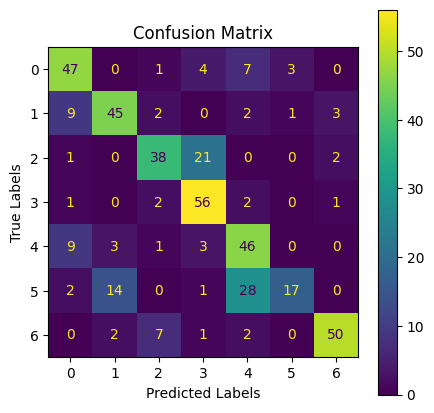


Epoch [63/50] - Loss: 0.0928 - Train Accuracy: 97.58%
Epoch [63/50] - Test Accuracy: 68.89%


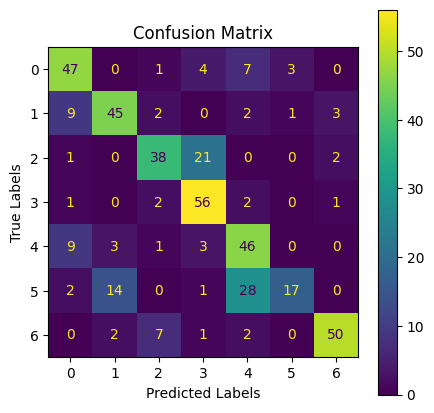


Epoch [64/50] - Loss: 0.0767 - Train Accuracy: 97.64%
Epoch [64/50] - Test Accuracy: 68.89%


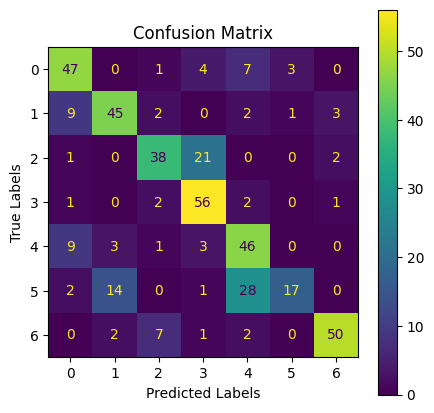


Epoch [65/50] - Loss: 0.0913 - Train Accuracy: 97.31%
Epoch [65/50] - Test Accuracy: 68.89%


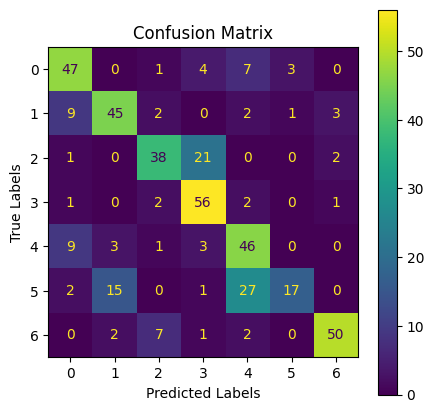


Epoch [66/50] - Loss: 0.0757 - Train Accuracy: 97.64%
Epoch [66/50] - Test Accuracy: 69.12%


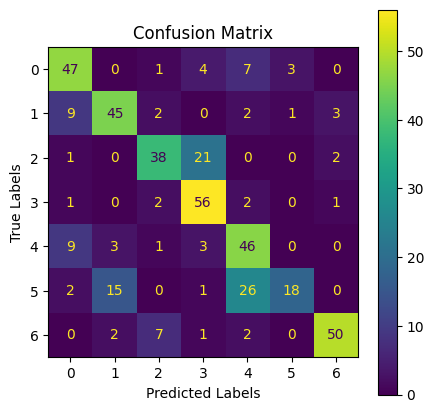


Epoch [67/50] - Loss: 0.0795 - Train Accuracy: 97.05%
Epoch [67/50] - Test Accuracy: 68.89%


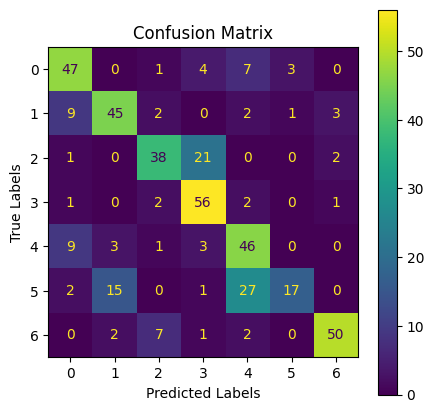


Epoch [68/50] - Loss: 0.0736 - Train Accuracy: 97.58%
Epoch [68/50] - Test Accuracy: 69.12%


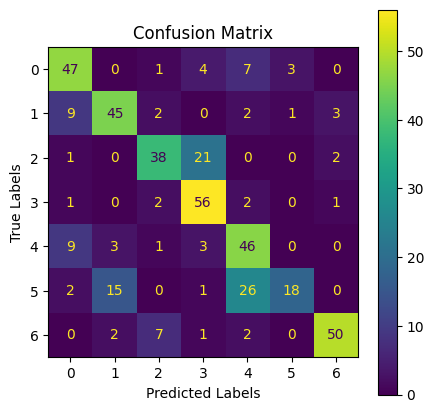


Epoch [69/50] - Loss: 0.0875 - Train Accuracy: 97.58%
Epoch [69/50] - Test Accuracy: 69.35%


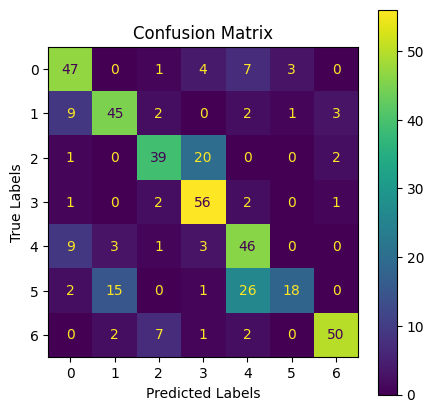


Epoch [70/50] - Loss: 0.0953 - Train Accuracy: 97.25%
Epoch [70/50] - Test Accuracy: 69.12%


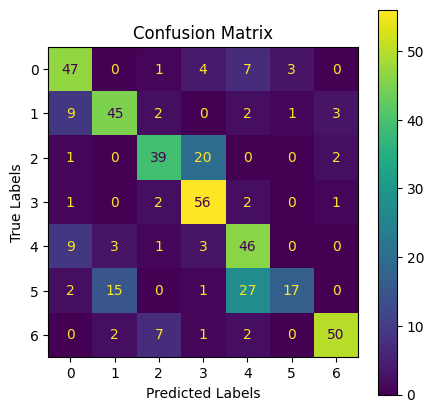


Epoch [71/50] - Loss: 0.0757 - Train Accuracy: 97.38%
Epoch [71/50] - Test Accuracy: 69.12%


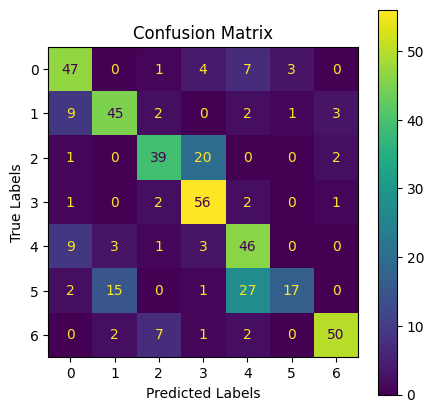


Epoch [72/50] - Loss: 0.0867 - Train Accuracy: 97.44%
Epoch [72/50] - Test Accuracy: 69.12%


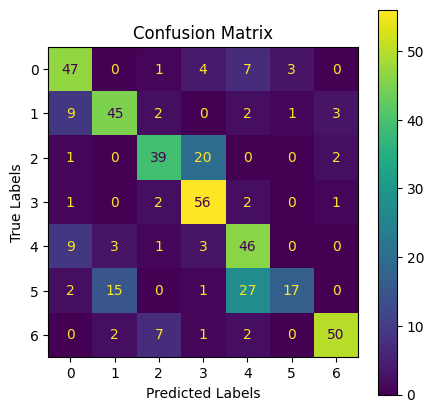


Epoch [73/50] - Loss: 0.0986 - Train Accuracy: 97.38%
Epoch [73/50] - Test Accuracy: 69.12%


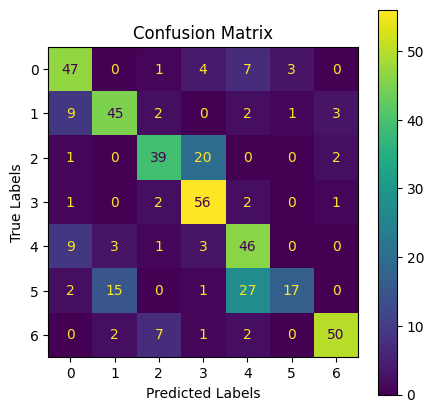


Epoch [74/50] - Loss: 0.0993 - Train Accuracy: 96.99%
Epoch [74/50] - Test Accuracy: 69.12%


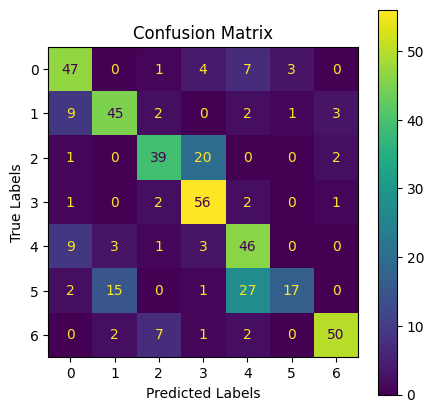


Epoch [75/50] - Loss: 0.0978 - Train Accuracy: 97.44%
Epoch [75/50] - Test Accuracy: 69.12%


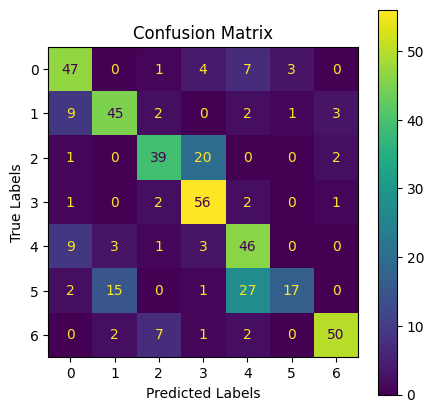


Epoch [76/50] - Loss: 0.0819 - Train Accuracy: 97.44%
Epoch [76/50] - Test Accuracy: 69.12%


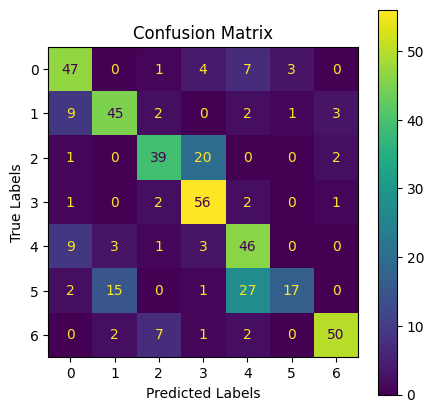


Epoch [77/50] - Loss: 0.0920 - Train Accuracy: 97.25%
Epoch [77/50] - Test Accuracy: 69.12%


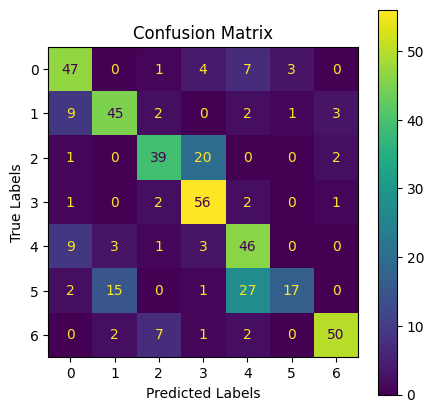


Epoch [78/50] - Loss: 0.0791 - Train Accuracy: 97.38%
Epoch [78/50] - Test Accuracy: 69.35%


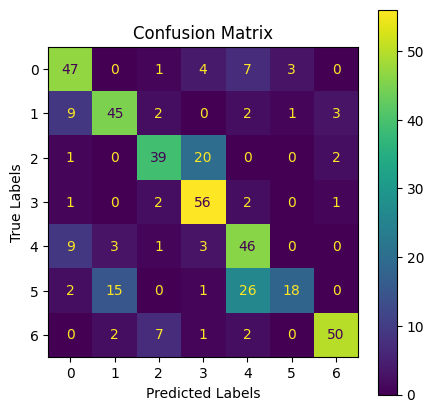


Epoch [79/50] - Loss: 0.1054 - Train Accuracy: 96.92%
Epoch [79/50] - Test Accuracy: 69.35%


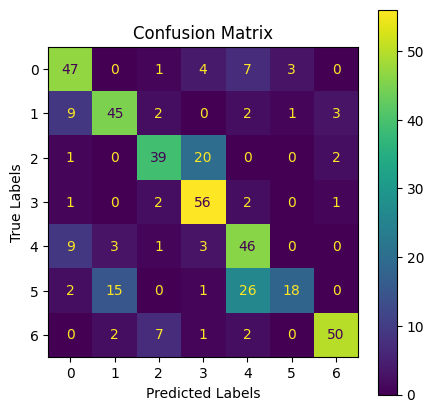


Epoch [80/50] - Loss: 0.1023 - Train Accuracy: 97.31%
Epoch [80/50] - Test Accuracy: 69.35%


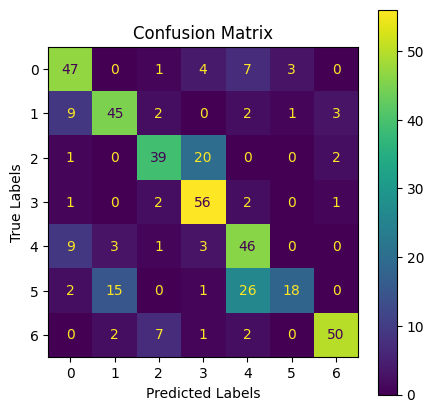


Epoch [81/50] - Loss: 0.0967 - Train Accuracy: 96.72%
Epoch [81/50] - Test Accuracy: 69.35%


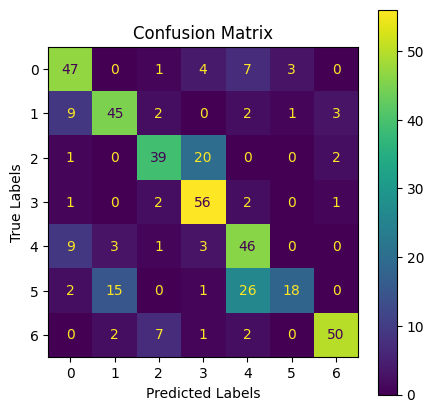


Epoch [82/50] - Loss: 0.0818 - Train Accuracy: 97.64%
Epoch [82/50] - Test Accuracy: 69.12%


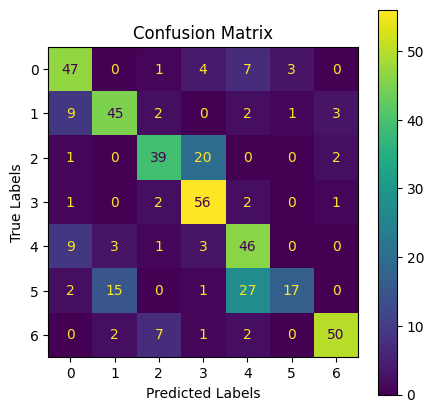


Epoch [83/50] - Loss: 0.0828 - Train Accuracy: 97.25%
Epoch [83/50] - Test Accuracy: 69.12%


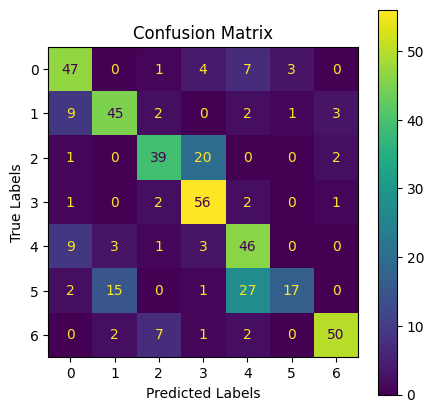


Epoch [84/50] - Loss: 0.0833 - Train Accuracy: 97.38%
Epoch [84/50] - Test Accuracy: 69.12%


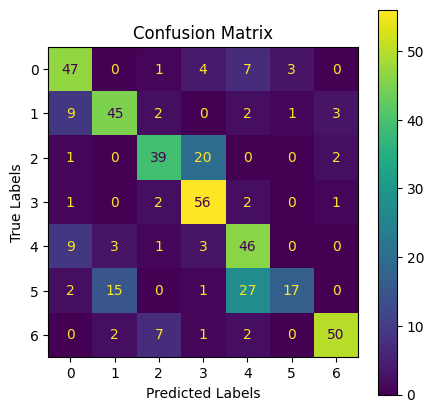


Epoch [85/50] - Loss: 0.0899 - Train Accuracy: 97.31%
Epoch [85/50] - Test Accuracy: 69.12%


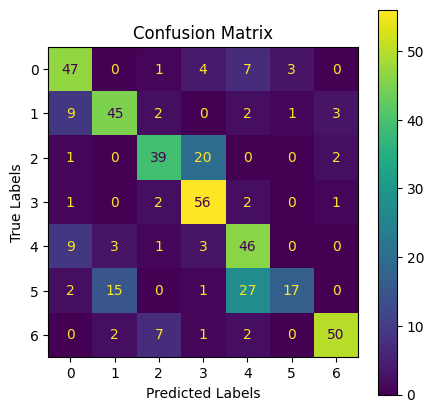


Epoch [86/50] - Loss: 0.0770 - Train Accuracy: 97.58%
Epoch [86/50] - Test Accuracy: 69.12%


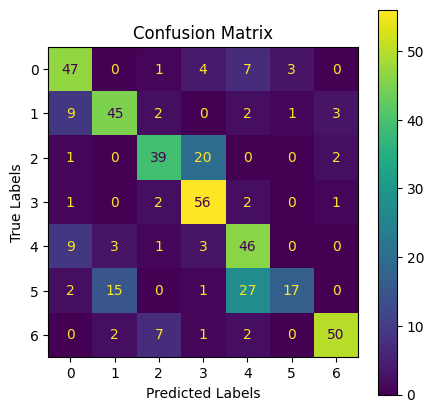


Epoch [87/50] - Loss: 0.0849 - Train Accuracy: 97.31%
Epoch [87/50] - Test Accuracy: 69.12%


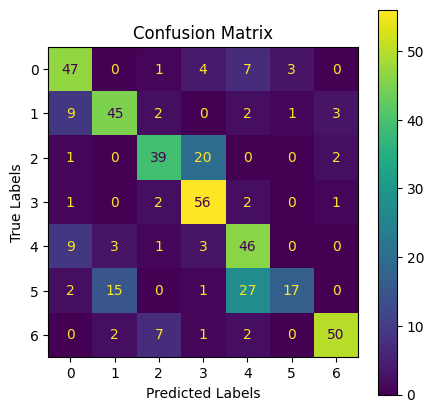


Epoch [88/50] - Loss: 0.0786 - Train Accuracy: 97.25%
Epoch [88/50] - Test Accuracy: 69.12%


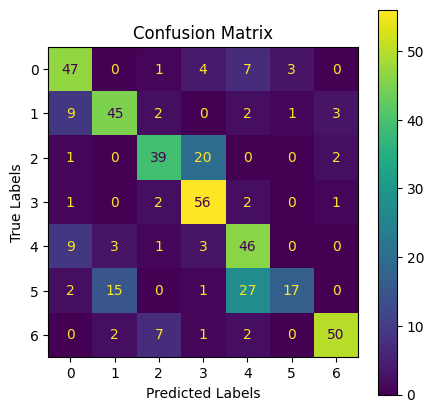


Epoch [89/50] - Loss: 0.0840 - Train Accuracy: 97.58%
Epoch [89/50] - Test Accuracy: 69.12%


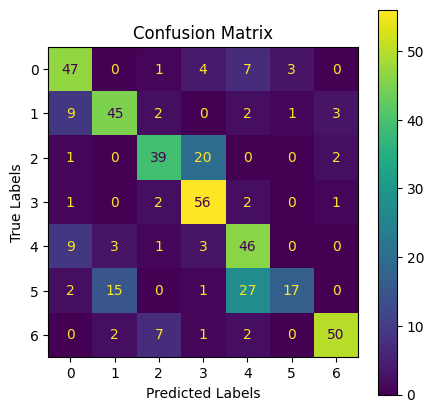


Epoch [90/50] - Loss: 0.0764 - Train Accuracy: 97.44%
Epoch [90/50] - Test Accuracy: 69.12%


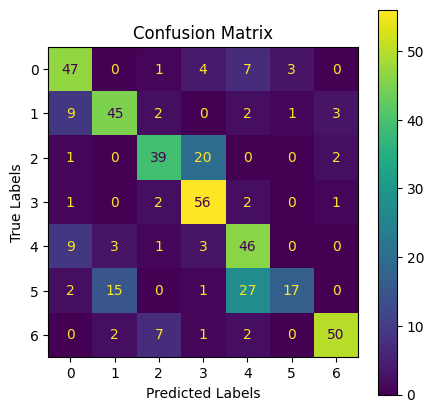


Epoch [91/50] - Loss: 0.0875 - Train Accuracy: 97.71%
Epoch [91/50] - Test Accuracy: 69.12%


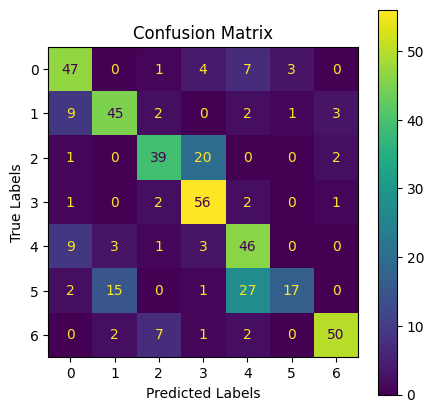


Epoch [92/50] - Loss: 0.0887 - Train Accuracy: 97.64%
Epoch [92/50] - Test Accuracy: 69.12%


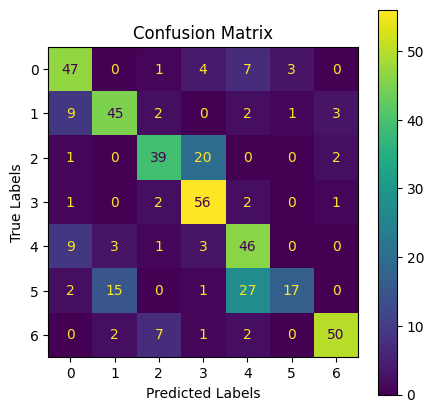


Epoch [93/50] - Loss: 0.0991 - Train Accuracy: 97.12%
Epoch [93/50] - Test Accuracy: 69.12%


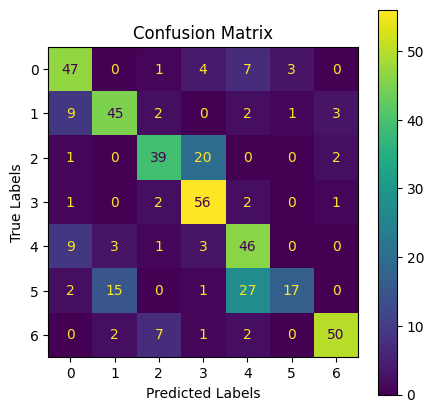


Epoch [94/50] - Loss: 0.0688 - Train Accuracy: 97.84%
Epoch [94/50] - Test Accuracy: 69.12%


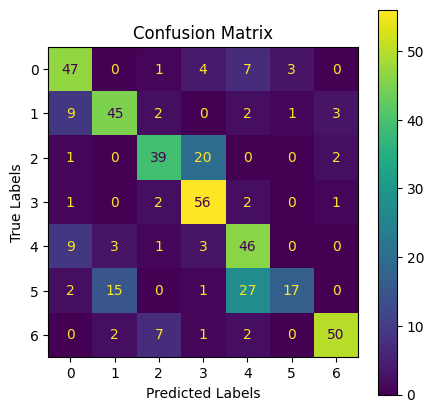


Epoch [95/50] - Loss: 0.0949 - Train Accuracy: 97.12%
Epoch [95/50] - Test Accuracy: 69.12%


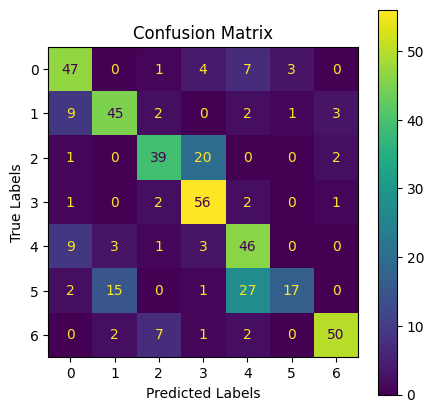


Epoch [96/50] - Loss: 0.0706 - Train Accuracy: 98.10%
Epoch [96/50] - Test Accuracy: 69.12%


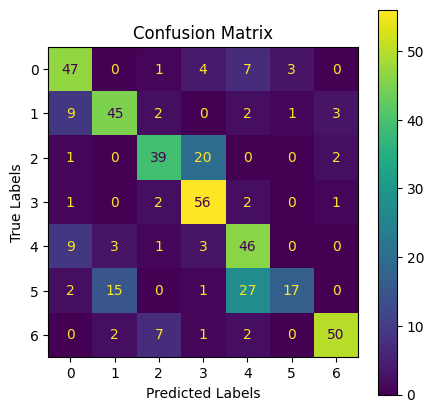


Epoch [97/50] - Loss: 0.0926 - Train Accuracy: 97.44%
Epoch [97/50] - Test Accuracy: 69.12%


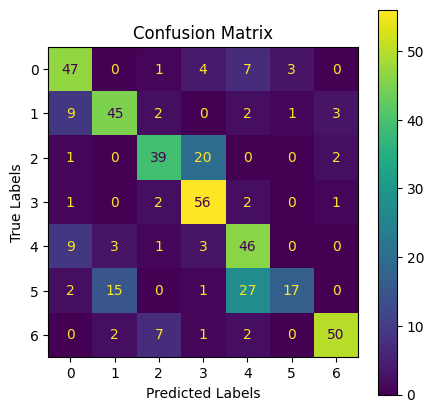


Epoch [98/50] - Loss: 0.0853 - Train Accuracy: 96.99%
Epoch [98/50] - Test Accuracy: 69.12%


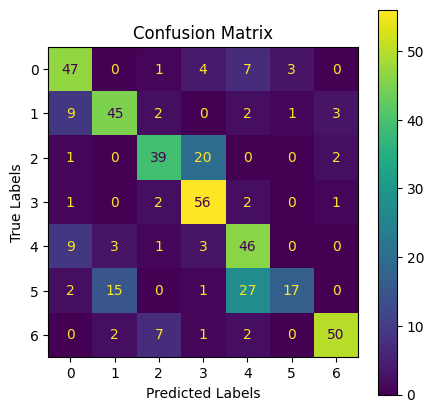


Epoch [99/50] - Loss: 0.0892 - Train Accuracy: 97.31%
Epoch [99/50] - Test Accuracy: 69.12%


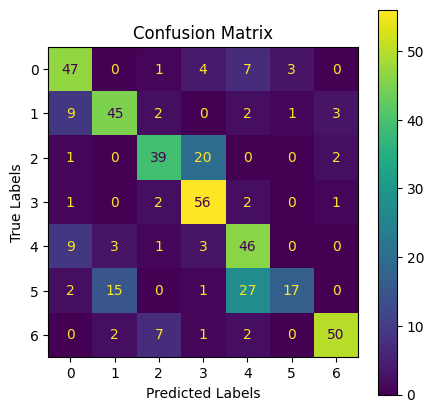


Epoch [100/50] - Loss: 0.0861 - Train Accuracy: 98.10%
Epoch [100/50] - Test Accuracy: 69.35%


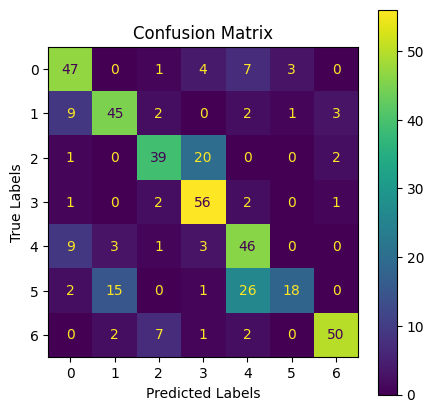

Training finished.


In [11]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []



for epoch in range(num_epochs+num_epochs_qat):
    if epoch == num_epochs:
        print("Moving model to QAT!")
        ai8x.fuse_bn_layers(model)
        ai8x.initiate_qat(model, qat_policy)
        compression_scheduler = distiller.CompressionScheduler(model)
        model.to(device)

    
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    # Use tqdm for the training loop
    with tqdm(dataset_train, desc=f'Epoch [{epoch + 1}/{num_epochs}]', unit='batch') as tqdm_loader:
        compression_scheduler.on_epoch_begin(epoch, metrics=vloss)
        for train_step, (inputs, labels) in enumerate(tqdm_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            compression_scheduler.on_minibatch_begin(epoch, train_step, steps_per_epoch, optimizer)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            compression_scheduler.before_backward_pass(epoch, train_step, steps_per_epoch, loss, optimizer=optimizer, return_loss_components=False)
            loss.backward()
            compression_scheduler.before_parameter_optimization(epoch, train_step, steps_per_epoch, optimizer)
            optimizer.step()
            compression_scheduler.on_minibatch_end(epoch, train_step, steps_per_epoch, optimizer)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update the tqdm progress bar
            tqdm_loader.set_postfix({'Loss': total_loss / (len(tqdm_loader) + 1), 'Accuracy': 100 * correct / total})
        compression_scheduler.on_epoch_end(epoch, optimizer)
    
    # Calculate and print training accuracy and loss for the current epoch
    train_accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {total_loss / len(dataset_train):.4f} - Train Accuracy: {train_accuracy:.2f}%')
    
    # Evaluation loop (unchanged)
    model.eval()
    correct = 0
    total = 0

    true_labels = []  # Initialize lists to store true labels and predicted labels
    predicted_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataset_val:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append true labels and predicted labels to the lists
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    
    # Calculate and print test accuracy for the current epoch
    test_accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Test Accuracy: {test_accuracy:.2f}%')

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Display the confusion matrix
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=dataset_labels)
    fig, ax = plt.subplots(figsize=(5,5))
    display.plot(cmap='viridis', values_format='d', ax=ax)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    # Speichern der Trainings-Werte
    train_losses.append(total_loss / len(dataset_train))
    train_accuracies.append(train_accuracy)

    # Speichern der Validierungs-Werte
    val_losses.append(test_accuracy)  # Falls du den Verlust brauchst, ergänze ihn
    val_accuracies.append(test_accuracy)
    
    # Adjust learning rate using the scheduler based on test accuracy
    scheduler.step(test_accuracy)

# Training is complete
print('Training finished.')

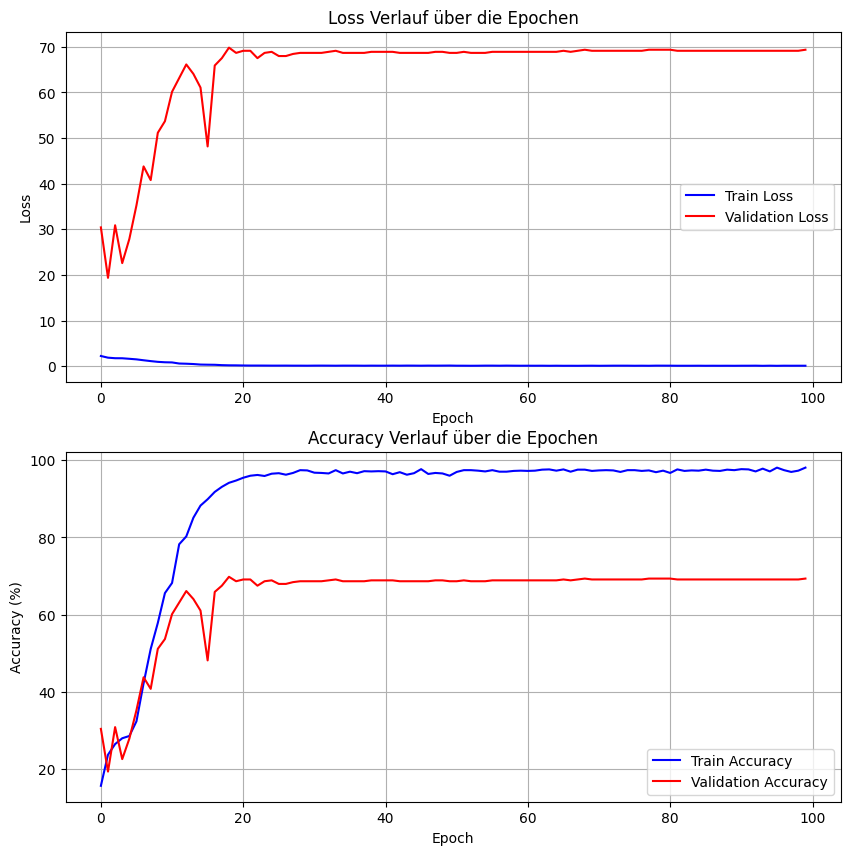

In [12]:
import matplotlib.pyplot as plt

# Erstelle zwei Diagramme: eins für den Loss und eins für die Accuracy
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# 📌 Loss-Graph
axs[0].plot(range(len(train_losses)), train_losses, label='Train Loss', color='blue')
axs[0].plot(range(len(val_losses)), val_losses, label='Validation Loss', color='red')
axs[0].set_title('Loss Verlauf über die Epochen')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# 📌 Accuracy-Graph
axs[1].plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy', color='blue')
axs[1].plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy', color='red')
axs[1].set_title('Accuracy Verlauf über die Epochen')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].grid()

plt.show()


## Evaluation

Test Accuracy: 68.30%


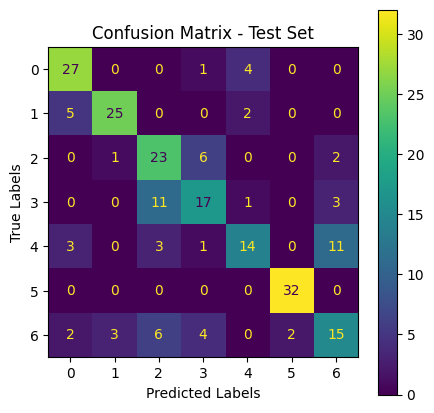

In [13]:
model.eval()

correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():  # Kein Gradienten-Tracking nötig
    for inputs, labels in dataset_test:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Speichere Labels für die Konfusionsmatrix
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Berechne die Testgenauigkeit
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Erzeuge eine Konfusionsmatrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Konfusionsmatrix visualisieren
display = ConfusionMatrixDisplay(conf_matrix, display_labels=dataset_labels)
fig, ax = plt.subplots(figsize=(5,5))
display.plot(cmap='viridis', values_format='d', ax=ax)

plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Generate sample for the KAT

In [ ]:
x, y = next(iter(dataset_test))
kat_image = (x[0].numpy()*128).astype(np.int64)
kat_image = np.clip(kat_image, -128, 127)

In [ ]:
plt.imshow(kat_image, cmap='viridis', vmin=-128, vmax=127)

In [ ]:
np.save('sample_mnist_40216.npy', kat_image, allow_pickle=False, fix_imports=False)

# Save the model checkpoint (compatible with the synthesizer)

In [ ]:
def save_checkpoint_custom(epoch, arch, model, optimizer=None, scheduler=None, extras=None, name=None, dir='.'):
    """Save a pytorch training checkpoint

    Args:
        epoch: current epoch number
        arch: name of the network architecture/topology
        model: a pytorch model
        optimizer: the optimizer used in the training session
        scheduler: the CompressionScheduler instance used for training, if any
        extras: optional dict with additional user-defined data to be saved in the checkpoint.
            Will be saved under the key 'extras'
        name: the name of the checkpoint file
        dir: directory in which to save the checkpoint
    """
    if not os.path.isdir(dir):
        raise IOError(ENOENT, 'Checkpoint directory does not exist at', os.path.abspath(dir))

    if extras is None:
        extras = {}
    if not isinstance(extras, dict):
        raise TypeError('extras must be either a dict or None')

    filename = 'checkpoint.pth.tar' if name is None else name + '_checkpoint.pth.tar'
    fullpath = os.path.join(dir, filename)
    print("Saving checkpoint to: %s" % fullpath)

    checkpoint = {'epoch': epoch, 'state_dict': model.state_dict(), 'arch': arch}
    with suppress(AttributeError):
        checkpoint['is_parallel'] = model.is_parallel
        checkpoint['dataset'] = model.dataset
        if not arch:
            checkpoint['arch'] = model.arch

    if optimizer is not None:
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        checkpoint['optimizer_type'] = type(optimizer)
    if scheduler is not None:
        cstate = scheduler.state_dict()
        # Falls distiller keine Masken angelegt hat (z.B. pruning/sparsity nicht genutzt)
        if 'masks_dict' not in cstate:
            cstate['masks_dict'] = {}
        checkpoint['compression_sched'] = cstate

    if hasattr(model, 'thinning_recipes'):
        checkpoint['thinning_recipes'] = model.thinning_recipes
    if hasattr(model, 'quantizer_metadata'):
        checkpoint['quantizer_metadata'] = model.quantizer_metadata

    checkpoint['extras'] = extras
    torch.save(checkpoint, fullpath)

In [ ]:
save_checkpoint_custom(num_epochs, "Custom1DCNNForImagev6_1", model, optimizer, scheduler, None, "qat_class_ASC_v6_1", './')

In [ ]:
print("Es hat alles funkioniert YEY")
print(device)

In [ ]:
print(model)